# Create grid of crimes


## 0. Import packages and data

In [1]:
# Beginning of code

# Load packages
import geopandas as gpd
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import unidecode

In [2]:
# Import the neighborhood's boundaries of Bogotá
upla = gpd.read_file("../../Data/upla")
# Remove the rural area of Bogotá
filtro = ~upla["UPlNombre"].str.contains("RIO")
urbano = upla.loc[filtro,].reset_index(drop = True)
# Import the administrative boundaries of Bogota
localidades = gpd.read_file("../../Data/localidades")
# Remove the rural area of Bogotá
filtro = ~localidades["LocNombre"].str.contains("SUMAPAZ")
bog = localidades.loc[filtro,].reset_index(drop = True)
bog_total = bog.copy()
bog_total = bog_total.dissolve(by = 'LocNombre', aggfunc = 'sum')
bog_total = gpd.GeoSeries(bog_total.geometry.unary_union)
# Combine both maps to hold the urban zone of Bogotá
bog = gpd.overlay(bog, urbano, how = "intersection", keep_geom_type = True)
bog = bog.dissolve(by = 'LocNombre', aggfunc = 'sum')
# Create an object without boundaries
bog_boundary = gpd.GeoSeries(bog.geometry.unary_union)

In [3]:
# Import the results of the survey of victimization
victimizacion = pd.read_excel("../../Data/victimización.xlsx")

In [4]:
# Import the consolidate dataset of crimes
unique_crimes = pd.read_csv('../../Data/unique_crimes.csv', sep = ";")

In [5]:
# Check the boundaries of the city to remove the observations that are not located in Bogota

# All the longitudes must be negatives
unique_crimes.loc[unique_crimes.LONGITUD > 0, "LONGITUD"] = -unique_crimes.loc[unique_crimes.LONGITUD > 0, "LONGITUD"]
# All the latitudes must be positive
unique_crimes.loc[unique_crimes.LATITUD < 0, "LATITUD"] = -unique_crimes.loc[unique_crimes.LATITUD < 0, "LATITUD"]

filtro_lon = unique_crimes.LONGITUD.between(bog_boundary.bounds.minx.values[0], bog_boundary.bounds.maxx.values[0])
filtro_lat = unique_crimes.LATITUD.between(bog_boundary.bounds.miny.values[0], bog_boundary.bounds.maxy.values[0])
unique_crimes = unique_crimes.loc[filtro_lon & filtro_lat,].reset_index(drop = True)

In [6]:
# We drop less than 1% of the data
(filtro_lon & filtro_lat).value_counts(normalize = True)

True     0.995043
False    0.004957
dtype: float64

In [7]:
# Fix the type of the date column
unique_crimes.FECHA = pd.to_datetime(unique_crimes.FECHA)
unique_crimes["Año-Mes"] = unique_crimes.FECHA.dt.strftime('%Y-%m')

## 1. Create a function to split a Bogotá in a grid

In [8]:
def make_grid(polygon, edge_size):
    """
    polygon : shapely.geometry
    edge_size : length of the grid cell
    """
    
    bounds = polygon.bounds
    # reescalada para trabajar con longitudes y latitudes
    delta = edge_size * 0.007 / 0.78
    x_coords = np.arange(bounds[0] + delta/2, bounds[2], delta)
    y_coords = np.arange(bounds[1] + delta/2, bounds[3], delta)
    combinations = np.array(list(product(x_coords, y_coords)))
    squares = gpd.points_from_xy(combinations[:, 0], combinations[:, 1])
    squares = [i.buffer(delta / 2, cap_style = 3) for i in squares]
    interseccion = [i.intersection(polygon) for i in squares]
    interseccion = [i.area != 0 for i in interseccion] 
    grilla = gpd.GeoDataFrame(
        {"geometry": squares, "interseccion": interseccion},
        crs = "EPSG:4326",
    )
    grilla["centroide"] = grilla.to_crs('+proj=cea').centroid.to_crs("EPSG:4326")
    grilla['LONGITUD_X'] = grilla["centroide"].values.x
    grilla['LATITUD_Y'] = grilla["centroide"].values.y
    
    return grilla

## 2. Build a grid of 1km x 1km size over Bogotá

In [9]:
grilla_bog = make_grid(polygon = bog_boundary[0], edge_size = 1)

In [10]:
# To make the Figure 9 we need a grid that include also the rural area of Bogota
grilla_bog_plot = make_grid(polygon = bog_total[0], edge_size = 1)
grilla_bog_plot.to_csv('../../Data/grilla_bogota.csv', sep = ";", index = False)

In [11]:
# Create a dataframe with the grid of only the elements that are over Bogotá
grilla_bog_int = grilla_bog[grilla_bog.interseccion]

<AxesSubplot:>

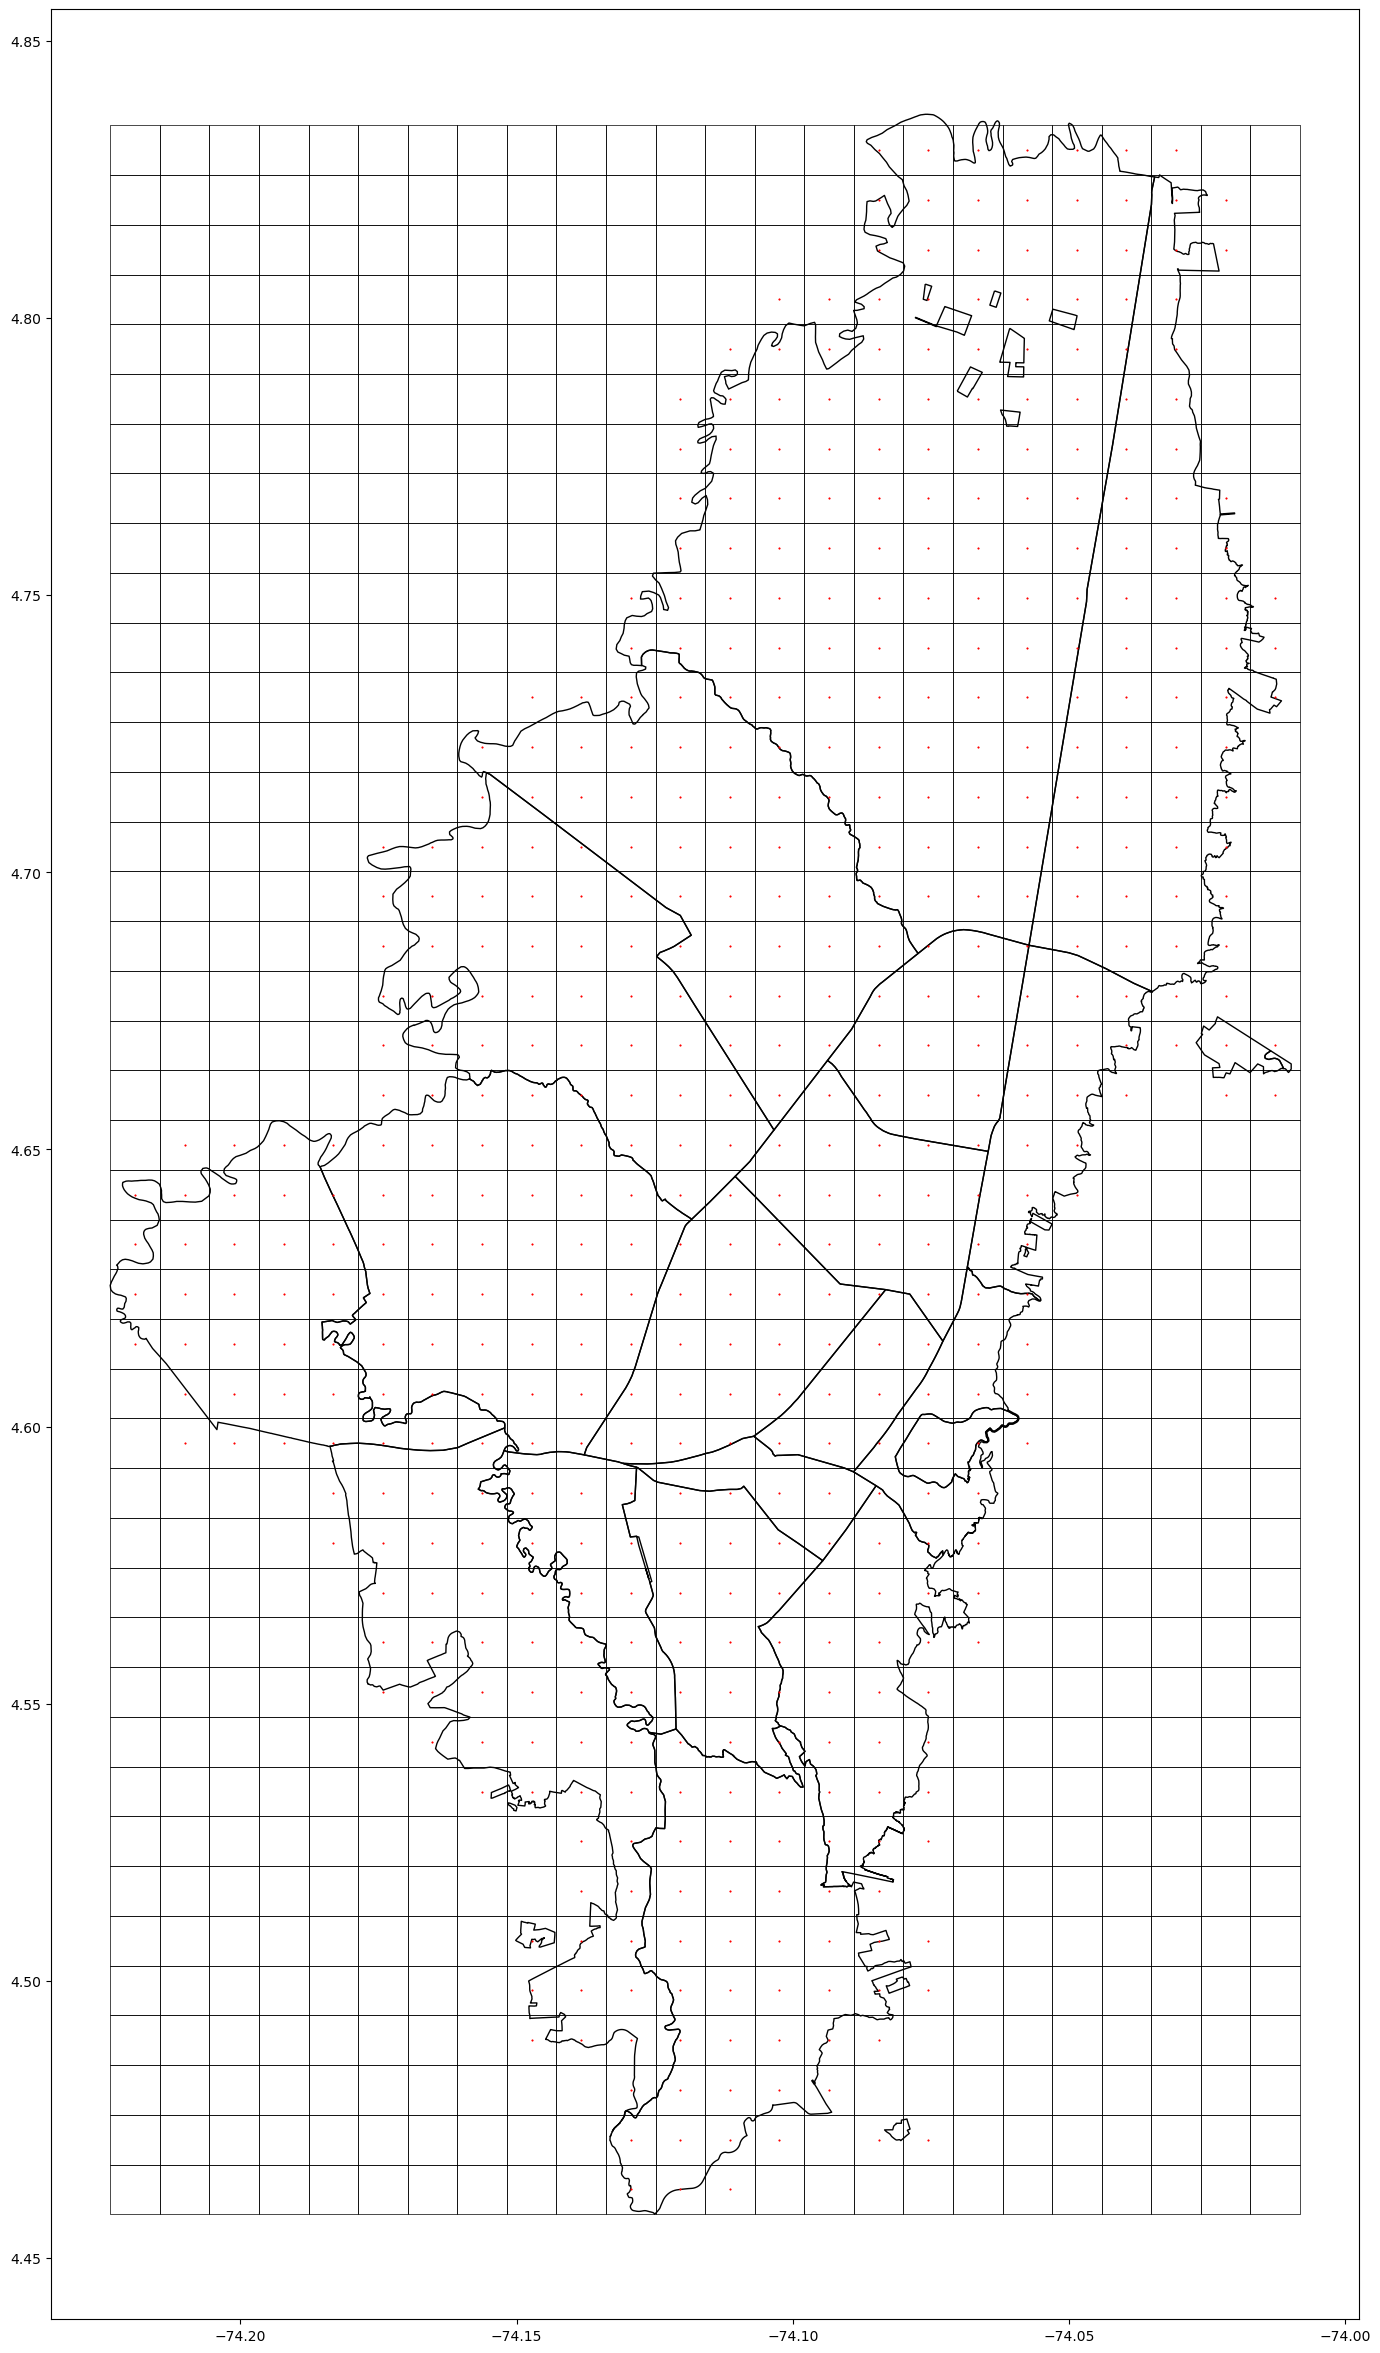

In [12]:
# Plot the grid to evaluate the results
fig, ax = plt.subplots(figsize = (20, 30), dpi = 100)

# Plot the administrative division of Bogotá
bog.plot(ax = ax, color = 'none', edgecolor = 'black')
# Plot the grid
grilla_bog.plot(ax = ax, color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
# Show the elements that are over Bogotá
grilla_bog_int.to_crs('+proj=cea').centroid.to_crs("EPSG:4326").plot(ax = ax, color = "red", markersize = 1, linewidth = 0.5)

## 3. Assign a grid cell to each of the crimes according to their proximity

In [13]:
unique_crimes['lon_rad'] = np.radians(unique_crimes['LONGITUD'])
unique_crimes['lat_rad'] = np.radians(unique_crimes['LATITUD'])
grilla_bog['lon_rad'] = np.radians(grilla_bog['LONGITUD_X'])
grilla_bog['lat_rad'] = np.radians(grilla_bog['LATITUD_Y'])
nbrs = NearestNeighbors(n_neighbors = 1, algorithm = 'ball_tree', metric = 'haversine').fit(grilla_bog[['lat_rad', 'lon_rad']])
unique_crimes['celda'] = list((nbrs.kneighbors(unique_crimes[['lat_rad','lon_rad']])[1])[:,0])

In [14]:
# We keep only the crimes contained in Bogota
grilla_bog['celda'] = grilla_bog.index
celdas_bogota = grilla_bog.loc[grilla_bog.interseccion, "celda"].unique()
unique_crimes = unique_crimes.loc[unique_crimes.celda.isin(celdas_bogota), ].reset_index(drop = True)

## 4. Aggregate crimes by day and cell by source of information

In [15]:
crimenes_diarios1 = unique_crimes.groupby(["FECHA", "celda"]).size().reset_index(name = "n").assign(BASE2 = "Total")
combinaciones = pd.DataFrame(list(product(unique_crimes["celda"].unique(), unique_crimes["FECHA"].unique(), ["Total"]))) \
    .rename(columns = {0: "celda", 1: "FECHA", 2: "BASE2"})
crimenes_diarios1 = combinaciones.merge(crimenes_diarios1, how = "left").fillna(0)
crimenes_diarios1["semana"] = crimenes_diarios1.FECHA.dt.isocalendar().week
crimenes_diarios1["año"] = crimenes_diarios1.FECHA.dt.isocalendar().year
crimenes_diarios1 = crimenes_diarios1.groupby(["semana", "año", "celda"]).n.median().reset_index(name = "promedio_semanal") \
    .merge(crimenes_diarios1, how = "right")

In [16]:
crimenes_diarios2 = unique_crimes.groupby(["FECHA", "celda", "BASE2"]).size().reset_index(name = "n")
combinaciones = pd.DataFrame(list(product(unique_crimes["celda"].unique(), unique_crimes["FECHA"].unique(), ['SIEDCO', 'NUSE']))) \
    .rename(columns = {0: "celda", 1: "FECHA", 2: "BASE2"})
crimenes_diarios2 = combinaciones.merge(crimenes_diarios2, how = "left").fillna(0)
crimenes_diarios2["semana"] = crimenes_diarios2.FECHA.dt.isocalendar().week
crimenes_diarios2["año"] = crimenes_diarios2.FECHA.dt.isocalendar().year
crimenes_diarios2 = crimenes_diarios2.groupby(["semana", "año", "celda", "BASE2"]).n.median().reset_index(name = "promedio_semanal") \
    .merge(crimenes_diarios2, how = "right")

In [17]:
crimenes_diarios_final = pd.concat([crimenes_diarios1, crimenes_diarios2]).reset_index(drop = True)

matriz_eventos_real = crimenes_diarios_final[crimenes_diarios_final.BASE2 == "Total"] \
    .pivot(index = "celda", columns = "FECHA", values = "promedio_semanal").fillna(0).reset_index()
matriz_eventos_real.columns.name = ""

matriz_eventos_subreporte = crimenes_diarios_final[crimenes_diarios_final.BASE2 == "NUSE"] \
    .pivot(index = "celda", columns = "FECHA", values = "promedio_semanal").fillna(0).reset_index()
matriz_eventos_subreporte.columns.name = ""

In [18]:
bog = bog.reset_index()

In [19]:
grilla_bog2 = gpd.GeoSeries(grilla_bog.loc[grilla_bog.interseccion, "geometry"])
grilla_bog["Localidad"] = np.nan

for i in tqdm(grilla_bog2.index):
    posicion = bog["geometry"].apply(lambda x: x.intersection(grilla_bog2[i]))
    posicion = ~posicion.geometry.is_empty
    valor = bog.loc[posicion, "LocNombre"].values[0]
    if posicion.sum() != 0:
        grilla_bog.loc[i, "Localidad"] = valor

100%|██████████| 547/547 [00:01<00:00, 323.88it/s]


In [20]:
grilla_bog.loc[grilla_bog.interseccion, "Localidad"].isna().sum()

0

In [21]:
victimizacion["Localidad"] = victimizacion["District"].str.upper().apply(unidecode.unidecode)
grilla_bog["Localidad"] = grilla_bog["Localidad"].str.upper().apply(lambda x: unidecode.unidecode(x) if (str(x) != "nan") else x)
grilla_bog = grilla_bog.merge(victimizacion[["Localidad", "Rep. Rate"]], how = "left", on = "Localidad")

In [22]:
matriz_eventos_real = grilla_bog.assign(celda = range(len(grilla_bog)))[["celda", "Localidad", "Rep. Rate"]] \
    .merge(matriz_eventos_real, how = "right", on = "celda")
matriz_eventos_subreporte = grilla_bog.assign(celda = range(len(grilla_bog)))[["celda", "Localidad", "Rep. Rate"]] \
    .merge(matriz_eventos_subreporte, how = "right", on = "celda")

In [23]:
subreporte_ccb = pd.concat([
    matriz_eventos_real[["celda", "Localidad", "Rep. Rate"]], 
    matriz_eventos_real.drop(columns = ["celda", "Localidad", "Rep. Rate"]).median(axis = 1)
], axis = 1).rename(columns = {0: "lambda"})

In [24]:
grilla_bog.to_csv('../../Data/grilla_bogota2.csv', sep = ";", index = False)
matriz_eventos_real.to_csv('../../Data/matriz_eventos_real.csv', sep = ";", index = False)
matriz_eventos_subreporte.to_csv('../../Data/matriz_eventos_subreporte.csv', sep = ";", index = False)
subreporte_ccb.to_csv('../../Data/subreporte_ccb.csv', sep = ";", index = False)

In [25]:
# End of the code